## Loading up packages

In [65]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [66]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
from magic_functions import process_frame

In [67]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/dmel/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/dmel/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/dmel/'
save_path2 = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TASEP-KS/dmel/'
gtf_name = 'Drosophila_melanogaster.BDGP6.32.103.gtf'
mutation = 'Fmr1'
samp_num = '3'
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [4]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [5]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [6]:
# clear up some memory by deleting original transcript list
transcripts.clear()

# Loading up the csv file.

In [68]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

In [69]:
elon_mutant = kat.load_elongation_rates(mutation + '_' + samp_num + '_elongation_rates', elon_path)
elon_control = kat.load_elongation_rates('control' + '_' + samp_num + '_elongation_rates', elon_path)

## Define functions

In [70]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
def get_pbar_from_count(tr_m):
    M = sum(tr_m)
    p = tr_m/M
    x=0
    pbar=[]
    for px in p:
        pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
        pbar.append(pbar_x)
        x = x+1
        if x  == len(p)-9:
            break
    pbar = np.array(pbar)
    return(pbar)

## Calculate Smoothed Vector Arrays

OK, note too self: this time around I really should probably find a way to do this such that the stuff that is going to be filtered out gets filtered out. 

In [71]:
max_pool = 20

with Pool(max_pool) as p:
    pool_control = list(
        tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                   data_control),
            total=len(data_control)
        )
    )    
# Why do some of these (12430) take so much longer than others? 

 65%|████████████████████████▏            | 20115/30710 [19:12<03:30, 50.29it/s]---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/keegan_analysis_tools.py, line 236:

234     def get_weights(distances, min_range):
235         max_distance = np.max(distances[min_range])
236         weights = tricubic(distances[min_range] / max_distance)
237         return weights

---------------------------------------------------------------------------
---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in double_scalars
in /home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/keegan_analysis_tools.py, line 272:

270             sum_weight_xy = np.dot(np.multiply(xx, yy), weights)
272             mean_x = sum_weight_x / sum_weight
273             mean_y = sum_weight_y / sum_

In [72]:
with Pool(max_pool) as p:
    pool_mutant = list(
        tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                   data_mutant),
            total=len(data_mutant)
        )
    )    

 65%|████████████████████████▏            | 20115/30710 [19:22<03:49, 46.15it/s]---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/keegan_analysis_tools.py, line 236:

234     def get_weights(distances, min_range):
235         max_distance = np.max(distances[min_range])
236         weights = tricubic(distances[min_range] / max_distance)
237         return weights

---------------------------------------------------------------------------
---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in double_scalars
in /home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/keegan_analysis_tools.py, line 272:

270             sum_weight_xy = np.dot(np.multiply(xx, yy), weights)
272             mean_x = sum_weight_x / sum_weight
273             mean_y = sum_weight_y / sum_

## Determine KS statistic for all transcripts

In [73]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    gene_list = []
    tr_id = []
    len_list = []
    for tr_m, tr_c, transcript, index in zip(data_mutant, data_control, protein_coding, list(range(len(data_mutant)))):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15:
            position = np.array(list(range(len(tr_m))))
            smoothed_vec_m, cumul_m = pool_mutant[index]
            smoothed_vec_c, cumul_c = pool_control[index]
            ks = max(abs(cumul_m - cumul_c))
            ks_list.append(ks)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            len_list.append(len(tr_m))
            
    # reorganizing the lists into a dataframe. 
    df_b = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, len_list)))
    df_b.columns = ["gene_ID","transcript_ID", "ks_stat", "gene_length"]
    df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)
    
    # Clear out unneeded lists
    ks_list.clear()
    gene_list.clear()
    tr_id.clear()
    len_list.clear()

In [14]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

In [63]:
x = 0
for tr_m, tr_c, transcript, index in zip(data_mutant, data_control, protein_coding, list(range(len(data_mutant)))):
    if sum(tr_m) == 0 or sum(tr_c) == 0:
        x = x+1

In [64]:
x

9999

(0.0, 0.7)

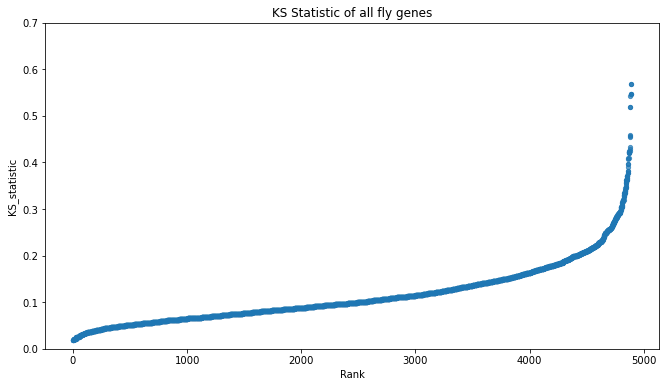

In [113]:
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), sorted(df_b["ks_stat"]), s=18, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS Statistic of all fly genes")
plt.ylim(0,0.7)

In [16]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df_b["gene_length"]:
    if i < 700:
        size_groups.append(1)
    elif i >= 700 and i < 1750:
        size_groups.append(2)
    elif i >= 1750:
        size_groups.append(3)
df_b["size_groups"] = size_groups

In [110]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.45)].groupby('gene_ID')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [111]:
len(diff_dist)

7

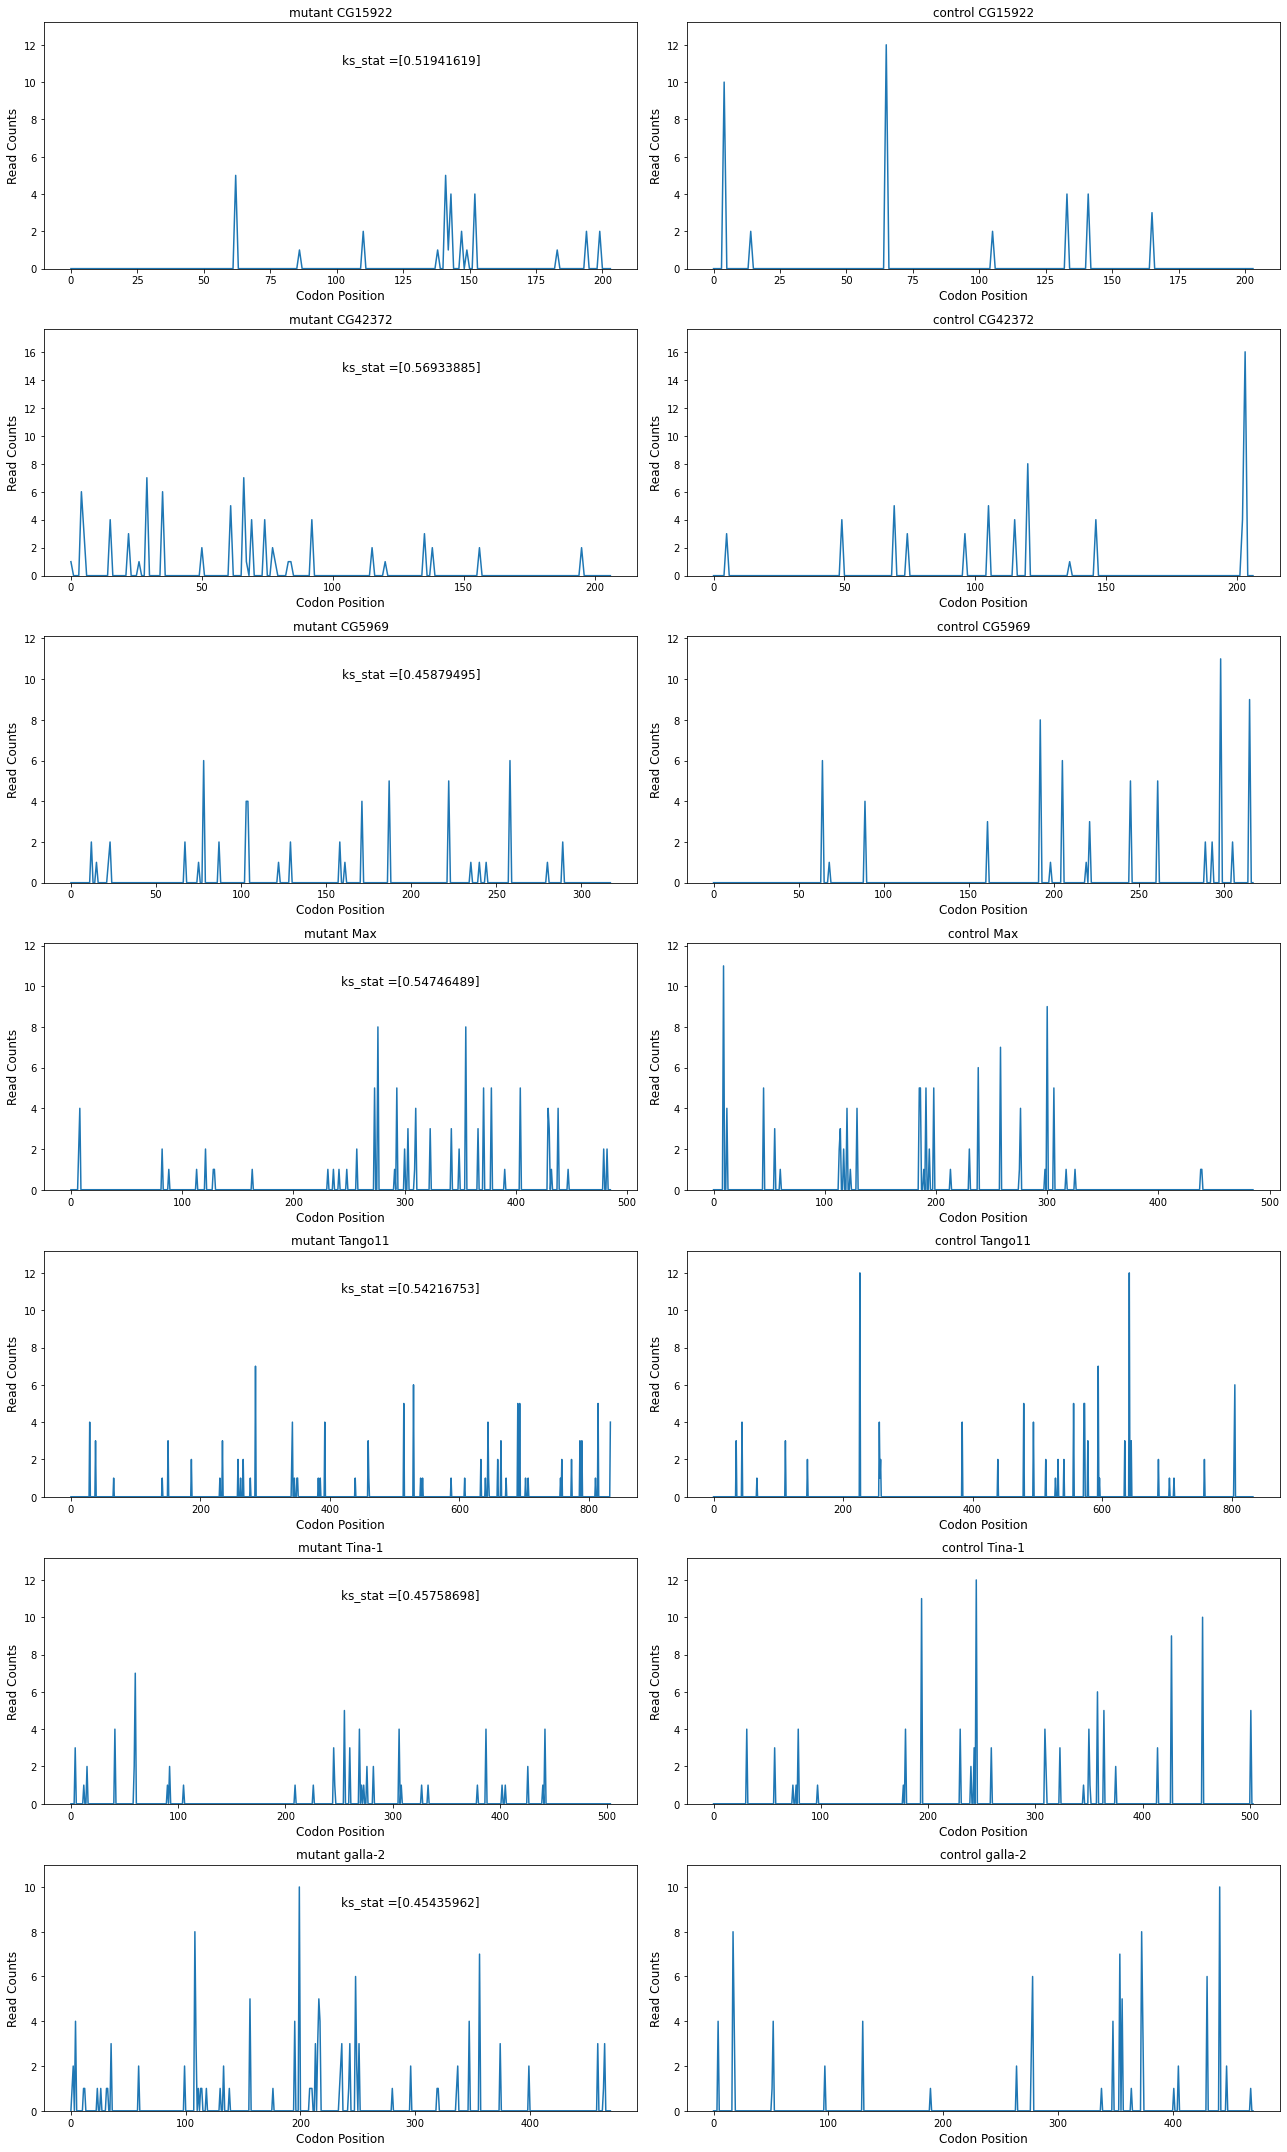

In [112]:
ax = kat.big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (18,30), fontsize = 12)

## Tasep-KS method

In [21]:
if pre_load == False:
    alt_p_list = []
    pbar_m_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, el_m, el_c, transcript in zip(data_mutant, data_control, elon_mutant, elon_control, protein_coding):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5 and sum(el_c) > 0 and sum(el_m) > 0:
            alt_p_list.append(kat.alter_p(el_c, el_m))
            pbar_m_list.append(get_pbar_from_count(tr_m))
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())

In [22]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_alt_p = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       alt_p_list),
                total=len(alt_p_list)
            )
        )    

100%|██████████████████████████████████████| 1751/1751 [00:12<00:00, 137.54it/s]


In [23]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_pbar_m = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       pbar_m_list),
                total=len(pbar_m_list)
            )
        )    

100%|██████████████████████████████████████| 1751/1751 [00:13<00:00, 132.02it/s]


In [24]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    for pbar_m, alt_p in zip(pool_pbar_m, pool_alt_p):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5 and sum(el_c) > 0 and sum(el_m) > 0:
            sm_m, cumul_m = pbar_m
            sm_p, cumul_p = alt_p
            for d, i in zip(sm_m, list(range(len(sm_m)))):
                if d < 0:
                    sm_m[i] = 0.000000000000000000001
            ks = max(abs(cumul_p - cumul_m))
            ks_list.append(ks)
            
    # reorganizing the lists into a dataframe. 
    df_t = pd.DataFrame(list(zip(gene_list, tr_id, ks_list)))
    df_t.columns = ["gene_ID","transcript_ID", "ks_stat"]
    
    # Clear out unneeded lists
    ks_list.clear()
    gene_list.clear()
    tr_id.clear()
    alt_p_list.clear()
    pbar_m_list.clear()
    pool_alt_p.clear()
    pool_pbar_m.clear()

Text(0.5, 1.0, 'KS Statistic')

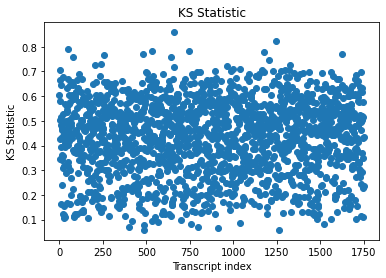

In [25]:
figure(figsize = (11,6))
plt.scatter(list(range(len(df_t["ks_stat"]))), sorted(df_t["ks_stat"], reverse = True), s=18, alpha = 0.7)
plt.ylabel("KS Statistic")
plt.xlabel("Rank")
plt.title("KS Statistic for all fly genes")

In [26]:
group = df_t[(df_t['ks_stat'] > 0.2) & (df_t['ks_stat'] < 0.205)].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [27]:
len(diff_dist)

11

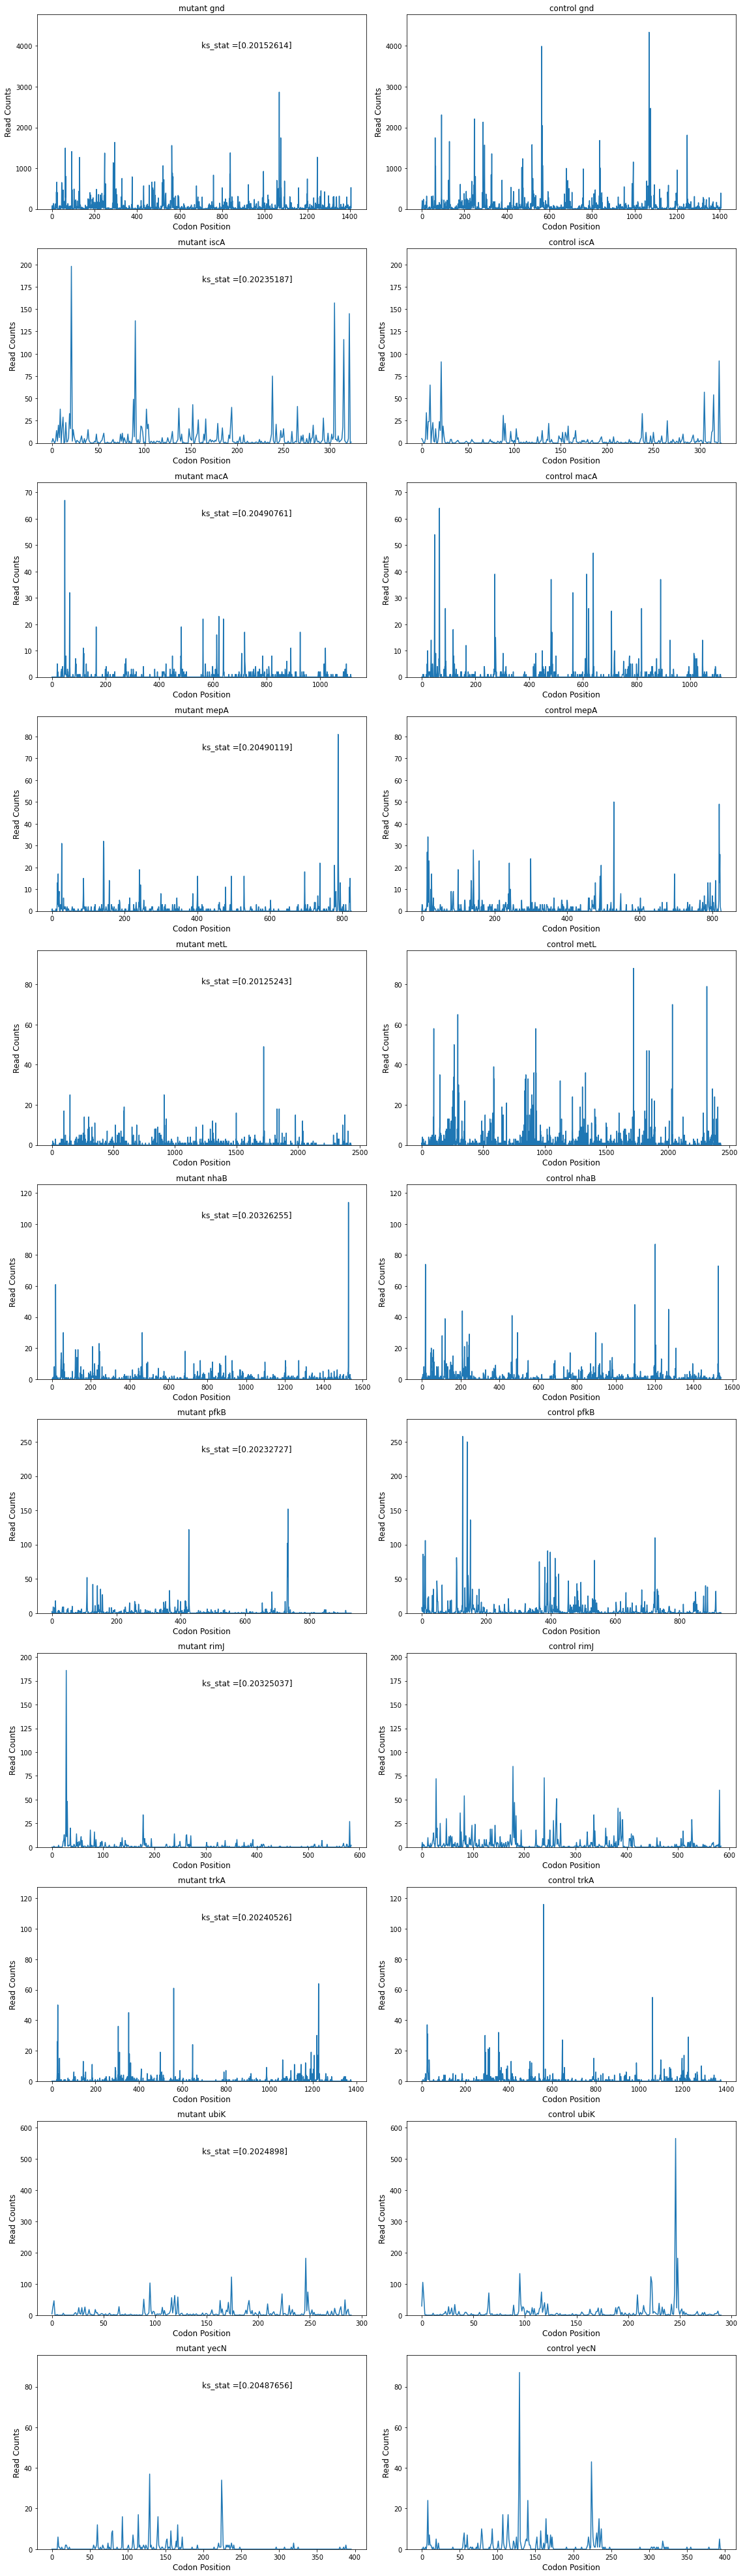

In [28]:
ax = kat.big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (16,55), fontsize = 12)

## Choose the gene of interest and smooth out the array.

In [99]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts('CG43103', 
                                           protein_coding, data_mutant, data_control)

In [100]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [101]:
sum(my_vec_control)

45

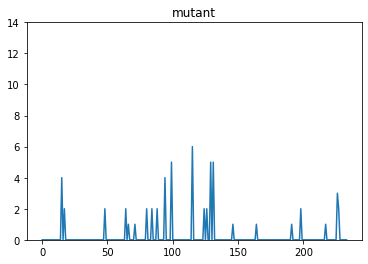

Text(0.5, 1.0, 'control')

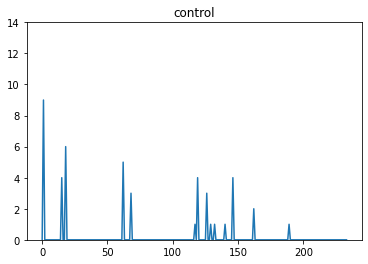

In [102]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.plot(my_vec_mutant)
plt.ylim([0,maxi+5])
plt.title("mutant")
plt.show()
plt.plot(my_vec_control)
plt.ylim([0,maxi+5])
plt.title("control")

In [103]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_position, my_vec_control+0.00000000001)

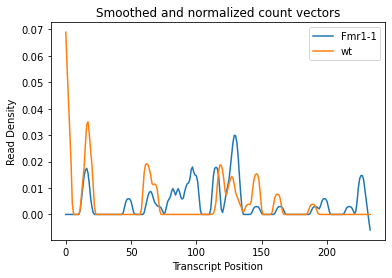

In [104]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

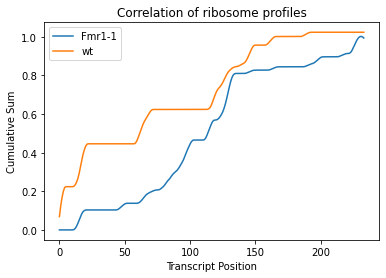

In [105]:
plt.plot(my_position, cumul_m, label = "Fmr1-1")
plt.plot(my_position, cumul_c, label = "wt")
plt.ylabel("Cumulative Sum")
plt.xlabel("Transcript Position")
plt.title("Correlation of ribosome profiles")
plt.legend()

In [107]:
ks = max(abs(cumul_m - cumul_c))
ks

0.42273970663800675

# Test Area

In [76]:
# Load in the table of Fmr1 targets
Fmr1_targets = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/Fmr1_targets/Fmr1_dmel_downreg_genes.txt',
                          names = ["gene_name"])

In [77]:
Fmr1_targets["gene_name_lower"] = Fmr1_targets["gene_name"].str.lower()

In [87]:
Fmr1_targets

,gene_name,gene_name_lower
0,CG15152,cg15152
1,comm,comm
2,fred,fred
3,CG15695,cg15695
4,CG8630,cg8630
...,...,...
674,Diap1,diap1
675,CG1671,cg1671
676,Sdc,sdc
677,CG1371,cg1371


In [90]:
df_f = pd.merge(df_b, Fmr1_targets, how = "inner", right_on = "gene_name", left_on = "gene_ID")

136/678, no good.

In [93]:
len(df_f["gene_ID"].unique())

136

Text(0.5, 1.0, 'KS- stat of 136 Fmr1 target genes')

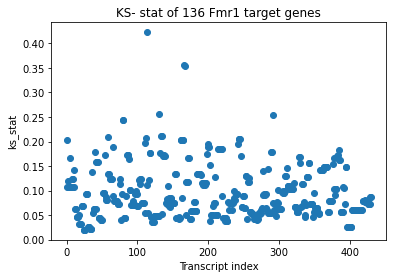

In [96]:
# plot the -10log p_values for the Fmr1 targets
plt.scatter(list(range(len(df_f['ks_stat']))), df_f['ks_stat'])
plt.ylabel("ks_stat")
plt.xlabel("Transcript index")
plt.title("KS- stat of 136 Fmr1 target genes")

In [98]:
df_f[df_f["ks_stat"] > 0.4]

,gene_ID,transcript_ID,ks_stat,gene_length,gene_name,gene_name_lower
114,CG43103,FBtr0304891,0.42274,234,CG43103,cg43103
